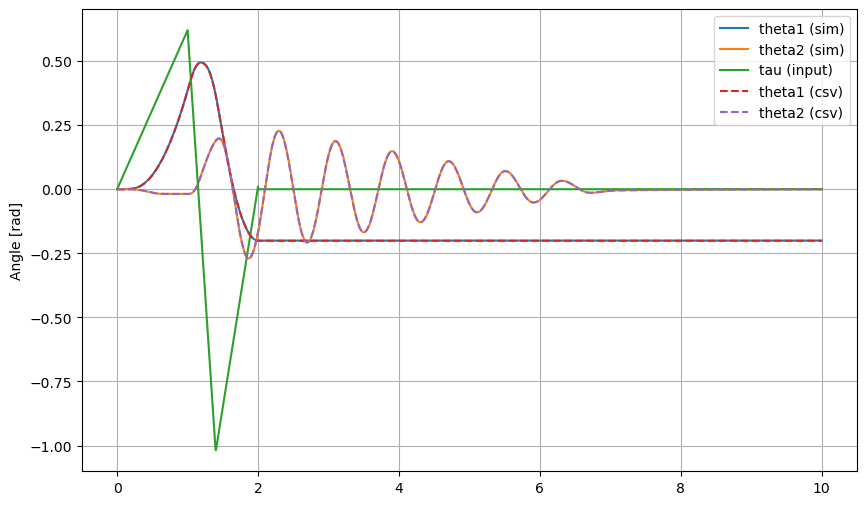

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================================
# Parameter (flach, ohne Klassen)
# ==========================================================
g = 9.81

# Geometrie
L1 = 0.155
L2 = 0.240
lP = 0.1917

# Massen
mS = 0.0274
mP = 0# 0.0510          # <- 0.0 wenn keine Zusatzmasse montiert ist
m2 = mS + mP

# Trägheitsmomente
J1_hat = 2.89e-2
J0_hat = J1_hat + m2 * L1**2

l2 = L2 / 2.0
J2_hat = (1/12) * mS * L2**2 + mS * l2**2 + mP * lP**2

# Reibungsparameter
mu_V1 = 50.91e-2
mu_H1 = 93.58e-3
mu_V2 = 1.332e-5
mu_H2 = 3.018e-4

epsilon = 0.01
tau_max = 4.0


# ==========================================================
# Eingangsfunktion aus 3.4 (HIER 1:1 einsetzen)
# ==========================================================
def input_tau(t: float) -> float:
    # TODO: exakt eure 3.4-Funktion hier einsetzen (dein bisheriger Block ist nur Platzhalter)
    if 0 < t < 1.0:
        tau = 0.62*t
    elif 1 <= t <= 1.4:
        tau = -4.12*t+4.74
    elif 1.4 < t < 2:
        tau = 1.72*t-3.43
    else:
        tau = 0.0

    return float(np.clip(tau, -tau_max, tau_max))


# ==========================================================
# Reibung: mu_V*v + mu_H*sgn(v) ~ mu_V*v + mu_H*tanh(v/epsilon)
# ==========================================================
def friction(v: float, mu_V: float, mu_H: float) -> float:
    return mu_V * v + mu_H * np.tanh(v / epsilon)


# ==========================================================
# Zustandsraummodell
# x = [theta1, theta1_dot, theta2, theta2_dot]
# ==========================================================
def furuta_dynamics(t, x):
    theta1, theta1_dot, theta2, theta2_dot = x
    tau = input_tau(t)

    # Reibmomente
    b1 = friction(theta1_dot, mu_V1, mu_H1)
    b2 = friction(theta2_dot, mu_V2, mu_H2)

    # Massenmatrix M(theta2)
    M11 = J0_hat + J2_hat * np.sin(theta2)**2
    M12 = m2 * L1 * l2 * np.cos(theta2)
    M = np.array([[M11, M12],
                  [M12, J2_hat]], dtype=float)

    # Rechte Seite r(x,u) (aus (2a),(2b))
    r1 = (
        tau
        + m2 * L1 * l2 * np.sin(theta2) * theta2_dot**2
        - J2_hat * np.sin(2 * theta2) * theta1_dot * theta2_dot
        - b1
    )

    r2 = (
        0.5 * J2_hat * np.sin(2 * theta2) * theta1_dot**2
        - m2 * g * l2 * np.sin(theta2)
        - b2
    )

    theta1_ddot, theta2_ddot = np.linalg.solve(M, np.array([r1, r2], dtype=float))

    return [theta1_dot, theta1_ddot, theta2_dot, theta2_ddot]


# ==========================================================
# Simulation
# ==========================================================
t_span = (0.0, 10.0)
x0 = [0.0, 0.0, 0.0, 0.0]  # <- muss zu validationSimulation.csv passen!

sol = solve_ivp(
    furuta_dynamics,
    t_span,
    x0,
    rtol=1e-6,
    atol=1e-9,
    max_step=1e-2
)


# ==========================================================
# Plot + CSV Vergleich
# ==========================================================
df = pd.read_csv("validationSimulation.csv")
t_csv = df["time"].values
theta1_csv = df["F: theta1"].values
theta2_csv = df["F: theta2"].values

plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label="theta1 (sim)")
plt.plot(sol.t, sol.y[2], label="theta2 (sim)")
plt.plot(sol.t, [input_tau(t) for t in sol.t], label="tau (input)")
plt.plot(t_csv, theta1_csv, "--", label="theta1 (csv)")
plt.plot(t_csv, theta2_csv, "--", label="theta2 (csv)")
plt.ylabel("Angle [rad]")
plt.legend()
plt.grid(True)
plt.show()